In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

2021-11-22 12:58:20.769610: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-22 12:58:20.769768: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Parcel irrigation data
irrigation = pd.read_csv('irrigation_machine.csv').drop('Unnamed: 0', axis=1)
parcel_columns = ['parcel_0', 'parcel_1', 'parcel_2']
parcels = irrigation[parcel_columns].values
sensors = irrigation.drop(parcel_columns, axis=1).values

from sklearn.model_selection import train_test_split
sensors_train, sensors_test, parcels_train, parcels_test = \
  train_test_split(sensors, parcels, test_size=0.3)

In [3]:
# Load parcel irrigation model to study its behaviour
from tensorflow.keras.models import load_model

irrigation_model = load_model('best_model.hdf5')
irrigation_model.summary()

2021-11-22 12:58:31.689848: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-11-22 12:58:31.690010: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-22 12:58:31.690121: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-FC4EGDV): /proc/driver/nvidia/version does not exist
2021-11-22 12:58:31.690859: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 128)               2688      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)              

In [12]:
# Access the model's layers
print(irrigation_model.layers)

# Filter dense layers
from tensorflow.keras.layers import Dense

dense_layers = [layer for layer in irrigation_model.layers if type(layer) == Dense]
print('\n', dense_layers)

[<keras.layers.core.Dense object at 0x7f555770e310>, <keras.layers.core.Dropout object at 0x7f555770ef70>, <keras.layers.core.Dense object at 0x7f55546378b0>, <keras.layers.core.Dropout object at 0x7f5554637f40>, <keras.layers.core.Dense object at 0x7f55545f9c70>, <keras.layers.core.Dropout object at 0x7f55546019d0>, <keras.layers.core.Dense object at 0x7f5554601100>, <keras.layers.core.Dropout object at 0x7f55545f9dc0>, <keras.layers.core.Dense object at 0x7f5554608a90>, <keras.layers.core.Dropout object at 0x7f555460e760>, <keras.layers.core.Dense object at 0x7f555460e280>]

 [<keras.layers.core.Dense object at 0x7f555770e310>, <keras.layers.core.Dense object at 0x7f55546378b0>, <keras.layers.core.Dense object at 0x7f55545f9c70>, <keras.layers.core.Dense object at 0x7f5554601100>, <keras.layers.core.Dense object at 0x7f5554608a90>, <keras.layers.core.Dense object at 0x7f555460e280>]


In [19]:
from tensorflow.keras.models import Model

def transformation_history(data):
  # Accumulate the different transformations the data undergoes when we perform forward propagation
  prediction_steps = [data]
  for dense_layer in dense_layers:
    # Extract input and output tensors from the model
    inputs, outputs = irrigation_model.input, dense_layer.output
    # Use information held by Keras to connect this tensors, through the irrigation model's layers
    intermediate_model = Model(inputs=inputs, outputs=outputs)
    # Predict using this sub-model in order to inspect the behaviour of the dense layer
    intermediate_predictions = intermediate_model.predict(sensors_train)

    prediction_steps.append(intermediate_predictions)
    
  return prediction_steps

prediction_steps = transformation_history(sensors_train)

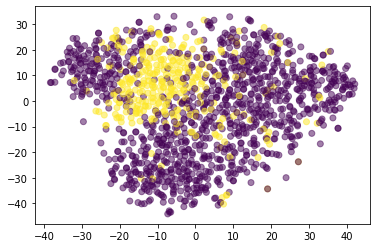

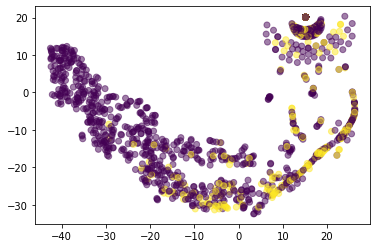

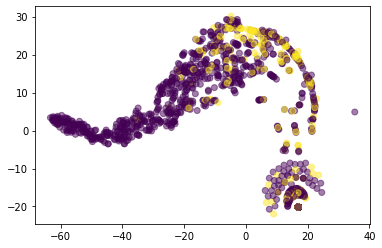

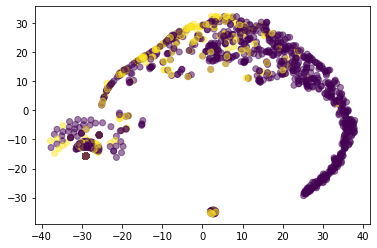

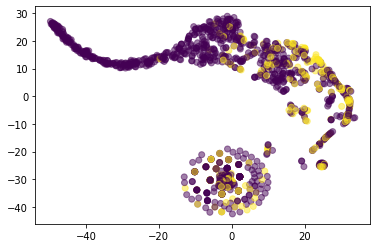

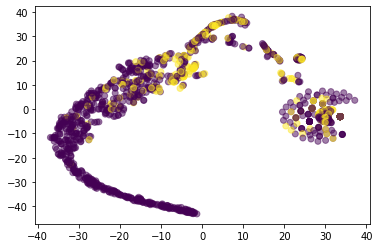

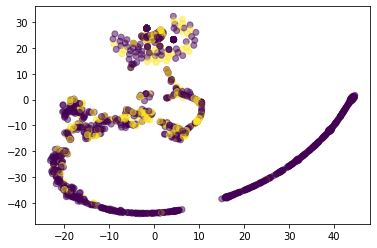

In [24]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def embedding_plot(datasets, categories, embedder=None):
  if not embedder: embedder = PCA(n_components=2)

  embeddings = [embedder.fit_transform(dataset) for dataset in datasets]

  for embedding, category in zip(embeddings, categories):
    plt.figure()
    plt.scatter(x=embedding[:,0], y=embedding[:,1], c=category, alpha=0.5)
    plt.plot()


embedding_plot(prediction_steps, len(prediction_steps) * [parcels_train[:,2]], embedder=TSNE())